# Reinforcement learning model implementation

## Overview

Here we will be modelling a sequential decision problem, where the information about the consequences of animals' actions is not necessarily immediately provided. Instead reward is based on the sequence of actions.

### The Model

The Actor-Critic method is a fundamental approach in reinforcement learning, a type of machine learning where an agent 
learns to make decisions by interacting with an environment. It combines two main components: the Actor and the Critic, 
each with a distinct role in learning optimal behavior. The Actor is responsible for making decisions or selecting actions based 
on the current state of the environment. It essentially maps states to actions, 
trying to choose actions that will maximize future rewards. The Actor's policy is updated based on feedback from the Critic, 
which evaluates the actions taken.
The Critic evaluates the actions taken by the Actor by estimating the value function, which is a prediction of future rewards. 
The value function helps in assessing how good a particular state is for an agent. 
The Critic's feedback to the Actor is crucial for learning, as it helps the Actor adjust its policy towards more rewarding actions.
In the Actor-Critic method, both the Actor and the Critic are updated iteratively based on their performance. The Critic's evaluation 
helps to adjust the Actor's policy parameters through a learning process, often implemented using methods like Temporal 
Difference (TD) learning. The Actor's role is to adjust its policy to increase the expected future rewards, guided by 
the Critic's value function.

### Our setting

In our model environment there are three states, denoted as `u1`, `u2` and `u3`. Within `u1` an animal can choose one out of three possible actions: press the `L`, `R` or `C` lever. The `L` and `R` levers deliver immediate reward (`r(u)`) of 1 and 2 respectively, whereas lever `C` delivers a mild punishment of -1 and probabilistically takes the animal to one of the other two staes: `u2` and `u3`. Withtin `u3` the animal can press levers `L` and `R` to receive reward of 8 or punishment of -8 respectively. Within `u3` the animal can press levers `L` and `R` to receive reward of 4 or 0 respectively. We will be trying two algorithms accounting for two possible policies: flat or equiprobabale policy, where the decision making is purely probabilistic at all states and updating policy, where the animal will be learning to make optimal choices trial by trial with the actor-critic learning rules. The learning is basically based on three rules: 
1) prediction error delta is calculated as `delta = r(u) + v(u') - v(u)`, where `u'` denotes the next state
2) prediction values `v(u)` are updated by `v(u) + critic_learning_rate * delta`
3) action values `m(u)` are updated by `m(u) = (1-decay_constant)*m(u) + actor_learning_rate*delta`

The probability of a certain action to be taken at a certain state P(a|u) is calculated as a softmax function of corresponding action values m(u). 


## Model Parameters

Thus, our learning model has several parameters:
1) Parameter `beta` is incorporated into the softmax function, calculating the probability of taking a particular action (making a choice) at a given state. If `beta` is closer to 1 or 0, the animal's behaviour is modeled to be almost deterministic based on action values updated after previous trials, whereas lower `beta`s (e.g. 0.5) encourage exploratory behaviour. We shall start with `beta` = 1. 
2) `decay_constant` is used as a modification to the actor learning rule in order to further regulate the exploitation-exploration tradeoff. Larger `decay_constant`s are supposed to speed up adaptation to the environment at cost of overal performance. We shall start with `decay_constant` = 0 
3) Learning rates of actor and critic regulate the magnitude of updates to value predictions `v(u)` and action values `m(u)`. They are crucial for the speed and stability of learning.
4) Number of trials within each experiment is denoted by `Trials`
5) Number of experiments is denoted by `experiments`. Several experiments are needed to average our results.
6) `Actor_critic` parameter is 'False' if we are modelling the flat policy and 'True' if we are modelling the actor-critic learning process.

## Model implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# initialize a class for our environment


class Environment:
    def __init__(self):

        # Define states, actions, rewards, predictions (v), action values, action probabilities
        self.states = ['u1', 'u2', 'u3']
        self.actions = {'u1': ['L', 'C', 'R'],
                        'u2': ['L', 'R'],
                        'u3': ['L', 'R']}
        self.rewards = {'u1': {'L': 1, 'C': -1, 'R': 2},
                        'u2': {'L': 8, 'R': -8},
                        'u3': {'L': 0, 'R': 4}}
        self.action_values = {'u1': {'L': 0, 'C': 0, 'R': 0},
                              'u2': {'L': 0, 'R': 0},
                              'u3': {'L': 0, 'R': 0}}
        self.action_probabilities = {'u1': {'L': 1/3, 'C': 1/3, 'R': 1/3},
                                     'u2': {'L': 1/2, 'R': 1/2},
                                     'u3': {'L': 1/2, 'R': 1/2}}
        self.state_prediction = {'u1': 0, 'u2': 0, 'u3': 0}

    # Define update action values function

    def update_action_values(self, state, action, delta, Actor_critic):
        """ Funciton to update action values for each state-action pair
        Args:
            state: current state
            action: action taken in the current state
            delta: prediction error
            Actor_critic: boolean value to determine whether to update action values for actor-critic model
        Returns:
            Updated action values for the state-action pair

        """
        if Actor_critic == True:  # update action values only for actor-critic model
            self.action_values[state][action] = (
                1-decay_constant)*self.action_values[state][action] + actor_l_r*delta
        return (self.action_values[state][action])

    # define update probabilities function

    def update_probabilities(self, state, Actor_critic):
        """ Function to update action probabilities for each state-action pair
        Args:
            state: current state
            Actor_critic: boolean value to determine whether to update probabilities for actor-critic model
        Returns:
            Updated probabilities for the state-action pair

        """
        if Actor_critic == True:  # update probabilities only for actor-critic model
            # Get available actions for the state
            available_actions = self.actions[state]
            # Consider only available actions
            action_values = {
                a: self.action_values[state][a] for a in available_actions}
            exp_values = np.exp(beta * np.array(list(action_values.values())))
            total = np.sum(exp_values)
            probabilities = exp_values / total

            for action, prob in zip(available_actions, probabilities):
                self.action_probabilities[state][action] = prob

    # define take action function
    def take_action(self, state):
        """ Function to take action in the environment
        Args:
            state: current state
        Returns:
            action: action taken in the current state

        """
        action = np.random.choice(list(self.actions[state]), p=list(
            self.action_probabilities[state].values()))
        return action

    def update_predictions(self, state, learning_rate, delta):
        """ Function to update predictions for each state-action pair
        Args:
            state: current state
            learning_rate: learning rate
            delta: prediction error
        Returns:
            Updated predictions for the state-action pair

        """
        self.state_prediction[state] += learning_rate*delta
        return self.state_prediction

    # define restore to inital parameters function

    def restore(self):
        """ Function to restore environment to initial parameters
        Args:
            None
        Returns:
            Restored environment

        """

        self.action_values = {'u1': {'L': 0, 'C': 0, 'R': 0},
                              'u2': {'L': 0, 'R': 0},
                              'u3': {'L': 0, 'R': 0}}
        self.action_probabilities = {'u1': {'L': 1/3, 'C': 1/3, 'R': 1/3},
                                     'u2': {'L': 1/2, 'R': 1/2},
                                     'u3': {'L': 1/2, 'R': 1/2}}
        self.state_prediction = {'u1': 0, 'u2': 0, 'u3': 0}

    # define the function that runs our environment
    def run_maze(self, beta, decay_constant, actor_l_r, learning_rate, experiments, Trials):
        """ Function to run the environment
        Args:
            beta: inverse temperature
            decay_constant: decay constant
            actor_l_r: actor learning rate
            learning_rate: learning rate
            experiments: number of experiments
            Trials: number of trials
        Returns:
            probabilities_states: action probabilities for each state-action pair
            w_states: predictions for each state-action pair

        """

        # initialize arrays to store our data for plotting
        w_states = np.zeros((experiments, Trials, 3))
        probabilities_states = np.zeros((experiments, Trials, 3, 3))

        for experiment in range(experiments):
            self.restore()  # restore environment to initial parameters

            for trial in range(Trials):

                state = 'u1'  # initialize state
                action = self.take_action(state)  # take action
                reward = self.rewards[state][action]  # get reward
                self.update_probabilities(
                    state, Actor_critic)  # update probabilities

                if action in ['R', 'L']:
                    # calculate delta
                    delta = reward - self.state_prediction[state]

                    self.update_predictions(
                        state, learning_rate, delta)  # update predictions
                    self.update_action_values(
                        state, action, delta, Actor_critic)  # update action values
                    self.update_probabilities(
                        state, Actor_critic)  # update probabilities

                if action == 'C':
                    # choose new state probabilistically
                    new_state = np.random.choice(['u2', 'u3'])
                    # calculate delta
                    delta = reward + \
                        self.state_prediction[new_state] - \
                        self.state_prediction[state]

                    self.update_predictions(
                        state, learning_rate, delta)  # update predictions
                    self.update_action_values(
                        state, action, delta, Actor_critic)  # update action values
                    self.update_probabilities(
                        state, Actor_critic)  # update probabilities

                    state = new_state  # update state
                    # take action in new state
                    action = self.take_action(state)
                    # get reward in new state
                    reward = self.rewards[state][action]
                    # calculate delta in new state
                    delta = reward - self.state_prediction[state]

                    # update predictions in new state
                    self.update_predictions(state, learning_rate, delta)
                    # update action values in new state
                    self.update_action_values(
                        state, action, delta, Actor_critic)
                    # update probabilities in new state
                    self.update_probabilities(state, Actor_critic)

                # store data for plotting
                for i in range(len(list(self.states))):
                    for k in range(len(list(self.actions[self.states[i]]))):
                        probabilities_states[experiment, trial, i,
                                             k] = self.action_probabilities[self.states[i]][self.actions[self.states[i]][k]]
                    w_states[experiment, trial,
                             i] = self.state_prediction[self.states[i]]

        return probabilities_states, w_states

In [6]:
# define fuction to run the simulation and plot results
def plot_results():
    """ Function to run the simulation and plot results
    Args:
        None
    Returns:
        Plot of action probabilities and predictions

    """

    probabilities_states, w_states = env.run_maze(
        beta, decay_constant, actor_l_r, learning_rate, experiments, Trials)
    fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharey=False, sharex='col')
    styles = ['--', '', ':']

    for i in range(len(list(env.states))):
        for k in range(len(list(env.actions[env.states[i]]))):
            axs[1, i].plot(np.average(probabilities_states[:, :, i, k],
                           axis=0), styles[k], label=env.actions[env.states[i]][k])
            if i == 0:
                axs[1, i].set_ylabel('P[a|u]', fontsize=14)
            axs[1, i].legend(title='average across experiments')
            axs[1, i].set_xlabel('Trials', fontsize=14)

    for i in range(len(list(env.states))):
        axs[0, i].set_title(f'State = {env.states[i]}', fontsize=14)
        axs[0, i].plot(np.average(w_states[:, :, i], axis=0),
                       label='average across experiments')
        axs[0, i].plot(w_states[np.random.randint(0, 500), :, i],
                       'k:', label='random experiment')
        if i == 0:
            axs[0, i].set_ylabel('v(u)', fontsize=14)
        axs[0, i].legend(loc='lower right')

    axs[0][0].axhline(y=5, color='r', linestyle='--', label='optimal policy')
    axs[0][0].axhline(y=1, color='g', linestyle='--',
                      label='equiprobable policy')
    axs[0][0].legend(loc='lower right')

    axs[0][1].axhline(y=8, color='r', linestyle='--', label='optimal policy ')
    axs[0][1].axhline(y=0, color='g', linestyle='--',
                      label='equiprobable policy')
    axs[0][1].legend(loc='lower right')
    axs[0][2].axhline(y=4, color='r', linestyle='--', label='optimal policy')
    axs[0][2].axhline(y=2, color='g', linestyle='--',
                      label='equiprobable policy')
    axs[0][2].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In the flat (or equiprobable) policy paradigm, the animal keeps its policy  fixed so that all the actions have the same equal probabilities in each trial. Nevertheless the animal is still lerning to determine expected total future reward `v(u)` at each state `u`, hence 'evaluation'. We can calculate the expected `v(u)` at each state by averageing the outcomes of each actions. For state 2 it is `v(2) = 1/2(8 + (-8)) = 0`, for state `u3` it is `v(3) = 1/2(4+2) = 2` and for state `u1` – `v(1) = 1/3(1+2+(-1)+1/2(v(2)+v(3))) = 1`. 

Obviously optimal policy would be making the most beneficial action at each state, so that the reward expectation `v(u)` at each state would be `v(2) = 8 at u2`, `v(3) = 4` at `u3`. For `u1` the optimal choice is pressing the lever `C`, since it potentially leads to higher rewards. Given the probabilistic nature of choice between `u2` and `u3` having pressed lever `C` and the mild punishment -1, `v(1`) then is `v(1) = 1/2(v(2)+v(3))-1 = 5`. 

In the updating policy paradigm, the probability of animal's choosing a particular action at a particular state `P(a|u)` is dependent on action values `m(u)` which are updated trial by trial along with revard prediction `v(u)`, hence – the 'policy improvement'. Learning from each trial allows the model to gradually find an optimal or near-optimal policy through experience, a key aspect of reinforcement learning
In both paradigms the delta value is changed when there is discrepancy between the reward `r(u)` and its predictioon `v(u)`.

Let's firstly model the learning process with flat policy 

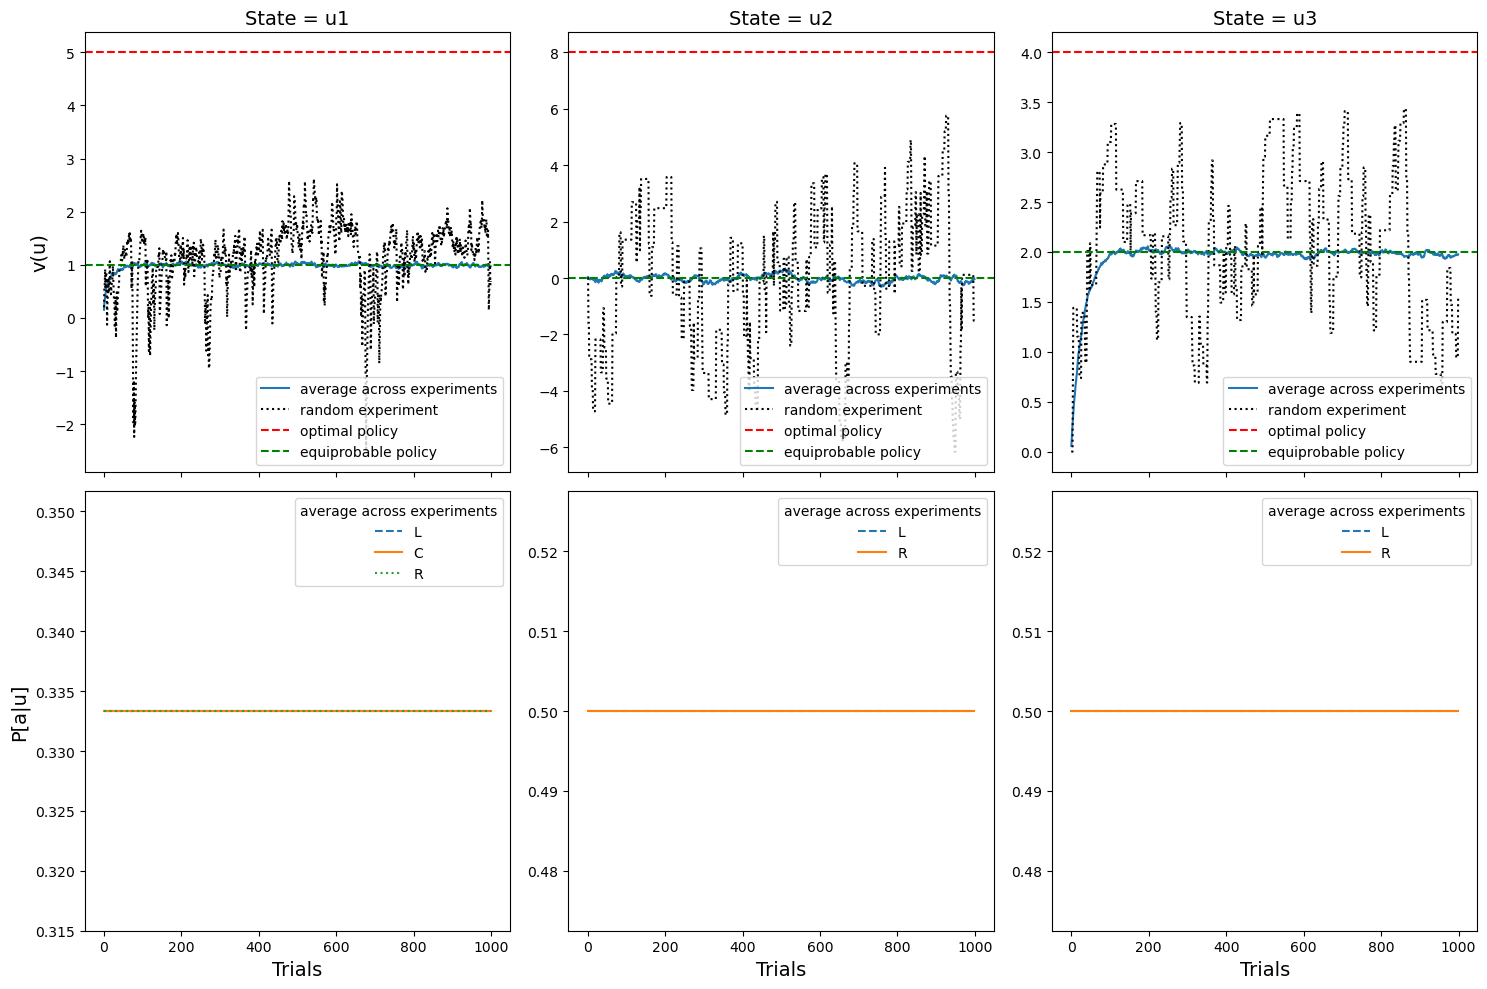

In [7]:
#set parameters
beta = 1
decay_constant = 0
actor_l_r = 0.075
learning_rate = 0.2
experiments = 500
Trials = 1000
Actor_critic = False
env=Environment()
#run simulation and plot results
plot_results()

We can see that in this mode the probabilities of taking all the actions at each particular state are equal and remain unchanged across the trials, so animal's choice of action is purely probabilistic. As expected when averaging across experiments the prediction `v(u)` nicely and quickly converges to our predicted values: 1 for `u1`, 0 for `u2` and 2 to u3 respectively. Individual experiment plot obviouslty fluctuates around this value because of the probabilistic nature of choice. 

Let's now run our environment in the actor-critic mode

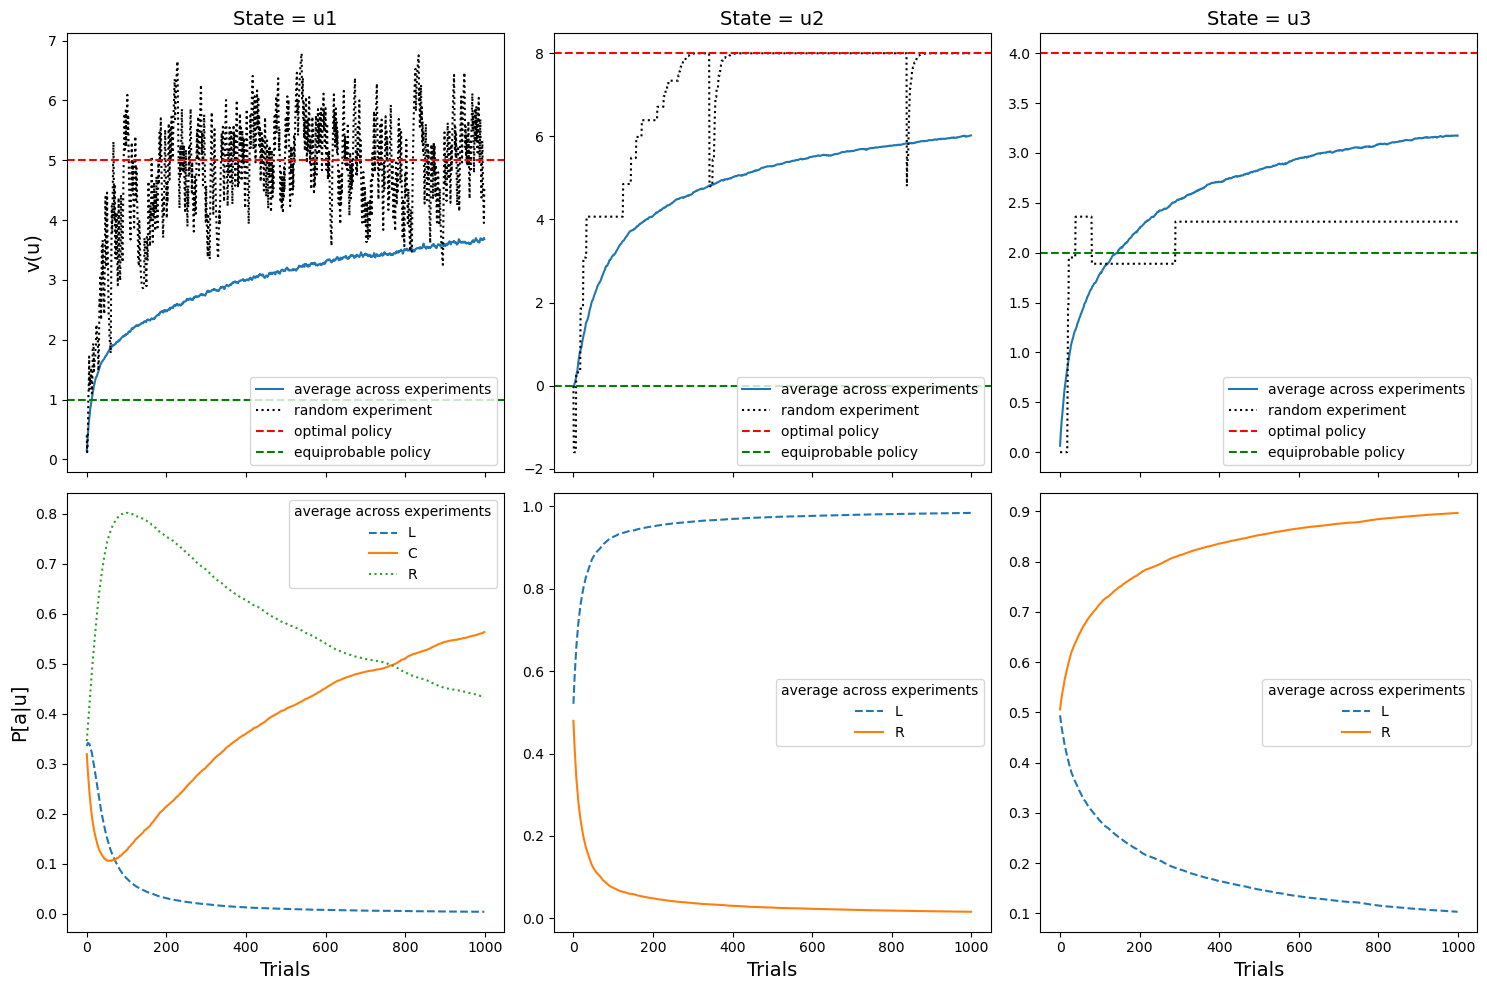

In [8]:
# set parameters
beta = 1
decay_constant = 0
actor_l_r = 0.075
learning_rate = 0.2
experiments = 500
Trials = 1000
Actor_critic = True
env = Environment()
# run simulation and plot results
plot_results()

In the Actor-critic mode we 'switch on' the actor learning rule – therefore action values are updated in each trial and subsequently probabilities of taking particular action change dynamically from trial to trial. While the dynamics is quite predictable in case of `u2` and `u3`, where the optimal choice is obvious, it is more unteresting in `u1`: At first, choosing lever `R` seems to be the most optimal as it delivers the immediate reward of 2, so the graph goes up sharply from the beginning of the experiment. However trial by trial the animal slowly learns that choosing the lever `C`, despite receiving a mild punishment of -1, can potentially lead to more benefits. Thus, starting at the lowest point at rougly 30th trial, the `C` graph rises steadily to surpass the `R` graph by roughly the 800th trial. This shift demonstrates the algorithm’s ability to adapt based on the balance of immediate and future rewards. Also, the prediction values do not converge to the calculated equiprobable policy values any more, but rather slowly climb up to the optimal policy values. This is because the learning mechanism adjusts the probabilities based on both immediate and long-term rewards, leading to an optimal strategy over time

Let's see what changes if we allow for more exploratory behavior by setting the parameter beta to 0.5

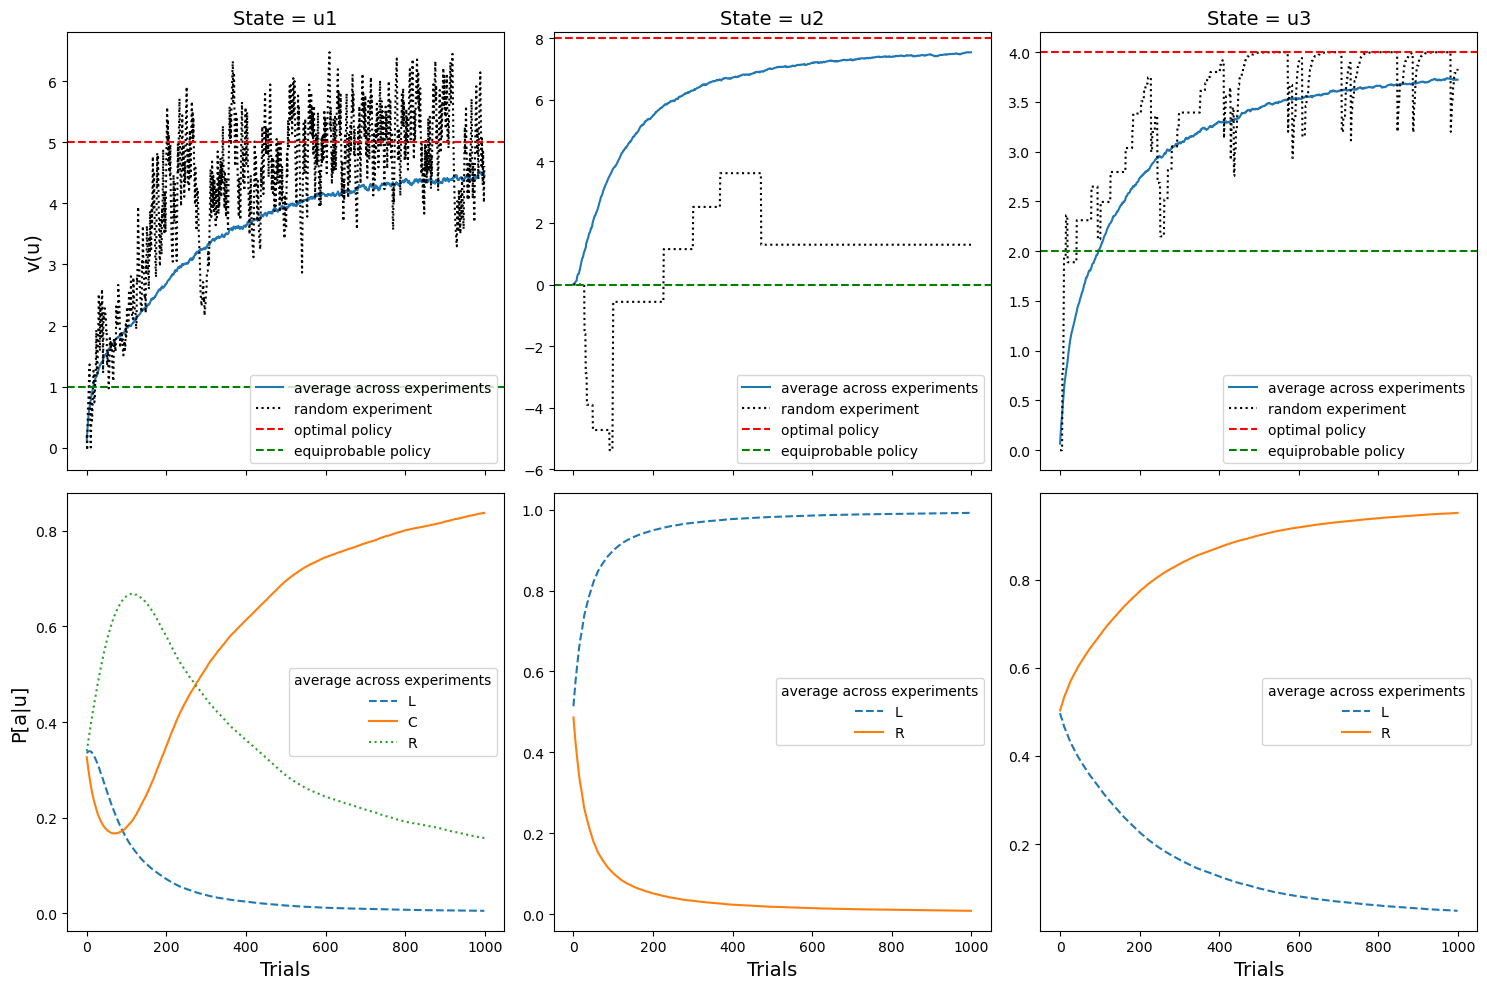

In [9]:
# set parameters
beta = 0.5
decay_constant = 0
actor_l_r = 0.075
learning_rate = 0.2
experiments = 500
Trials = 1000
Actor_critic = True
env = Environment()
# run simulation and plot results
plot_results()

We can see that compared to the previous case, the animal learns to make the most optimal choice much faster: the probability of pressing the `C` lever at `u1` surpasses that of `R` at around 300th trial already. This is because it's not overly biased towards actions with immediate high rewards (like lever `R`). Also the average prediction values are much closer to the expected optimal values by the last trial. This is because the model has had more opportunities to experience and learn from the different outcomes of each action due to increased exploration. As expected, lower beta allows faster adaptation to the environment. Adventurors are more successful than conservators!  

What happens if beta is even higher?

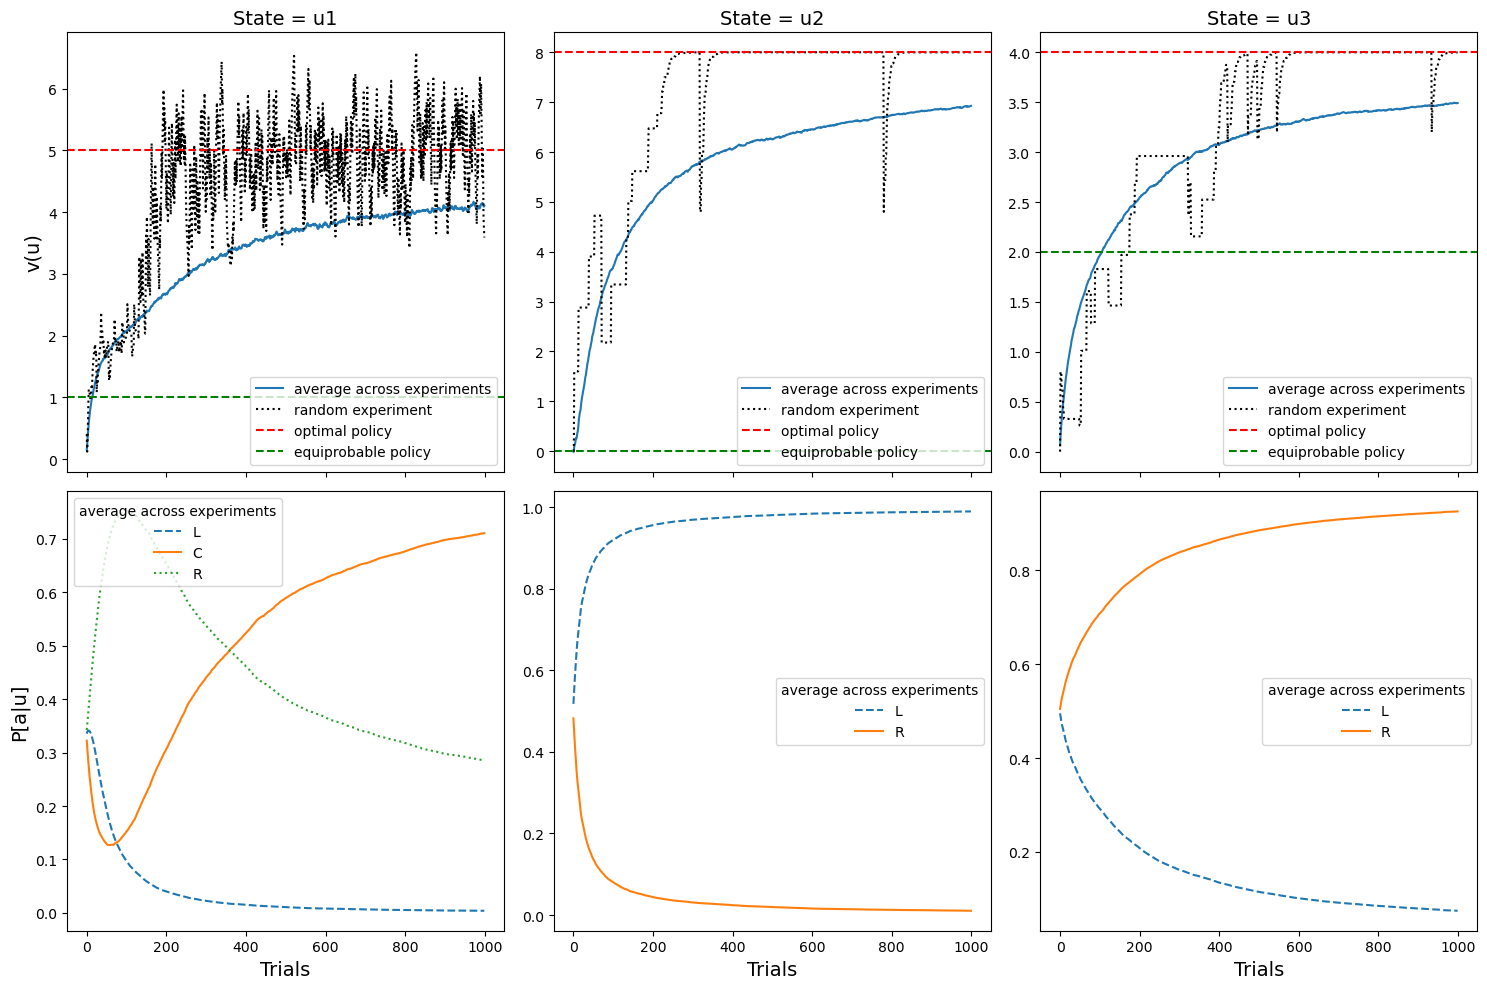

In [19]:
# set parameters
beta = 0.8
decay_constant = 0
actor_l_r = 0.075
learning_rate = 0.2
experiments = 500
Trials = 1000
Actor_critic = True
env = Environment()
# run simulation and plot results
plot_results()

We can see that animal still learns fast that pressing the lever `C` is the most optimal choice. However, being overexploratory also means that the probability of pressing `C` lever is not entirely dominating: it constitutes for 70%, while 30% is reserved for the `R` lever, which ultimately leads to slightly less reward collected overal within the 1000 trials, compared to the previous case. The results demonstrate the crucial balance in reinforcement learning between exploring new actions and exploiting known beneficial ones. Too much exploration can lead to less efficient reward collection, even when the optimal action is known. Overall, while high exploration can be beneficial in new environments, especially those that are highly dynamic or complex, there is a point at which it can become counterproductive

Next let's investigate the influence of learning rates. Let's decrease the critic's learning rate 10 fold first 

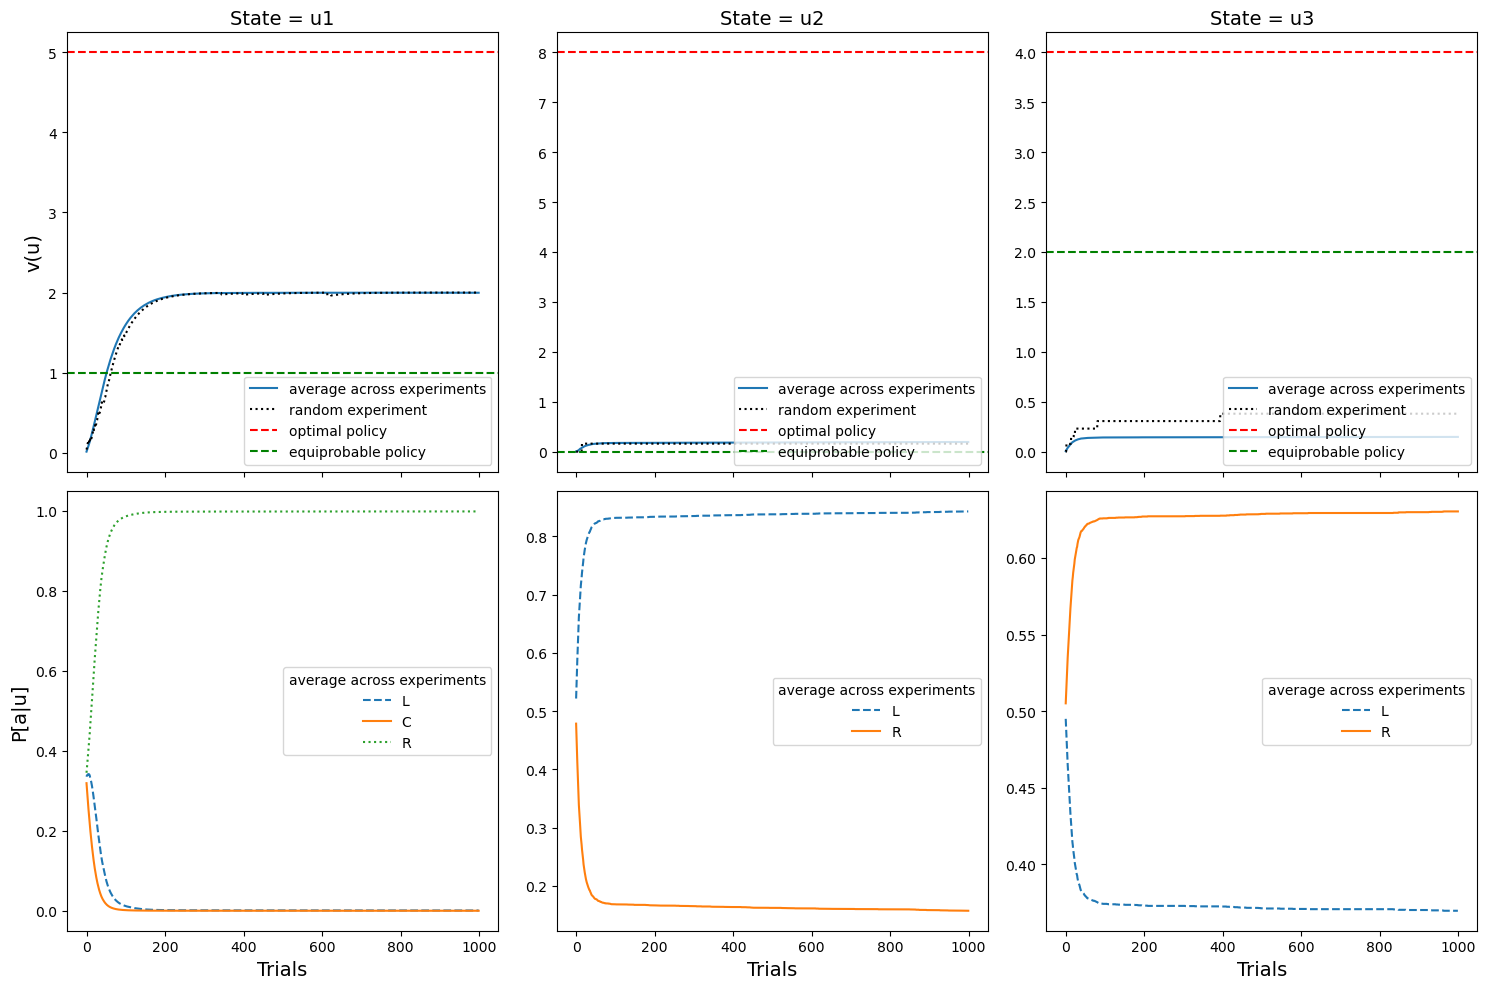

In [20]:
# set parameters
beta = 1
decay_constant = 0
actor_l_r = 0.075
learning_rate = 0.02
experiments = 500
Trials = 1000
Actor_critic = True
env = Environment()
# run simulation and plot results
plot_results()

As we can see, with such low critic's learning rate, the animal does not learn to choose the most optimal outcome at u1 (lever `C`), very early within the trials opting to go for immediate reward, provided by pressing the `R` and never changing this policy afterwards. As a result, predictions for the other two states never really get updated and stay at 0. Actually, levers `C` and `L` are virtually never chosen after about 50th trial. The learning rate is a crucial part of the predctions update rule, which it turn is part of delta calculations. And delta values are then used to update action values in order to change the policies regarding the most optimal lever choice. Thus reduced learning rate means these delta values are not effectively incorporated into the learning process, leading to minimal adjustments in action values and, consequently, the policy. Overall the model just becomes dumb and does not learn the optimal behavior at all.

Now let's see what happens if we decrease the actor learning rate 10 fold

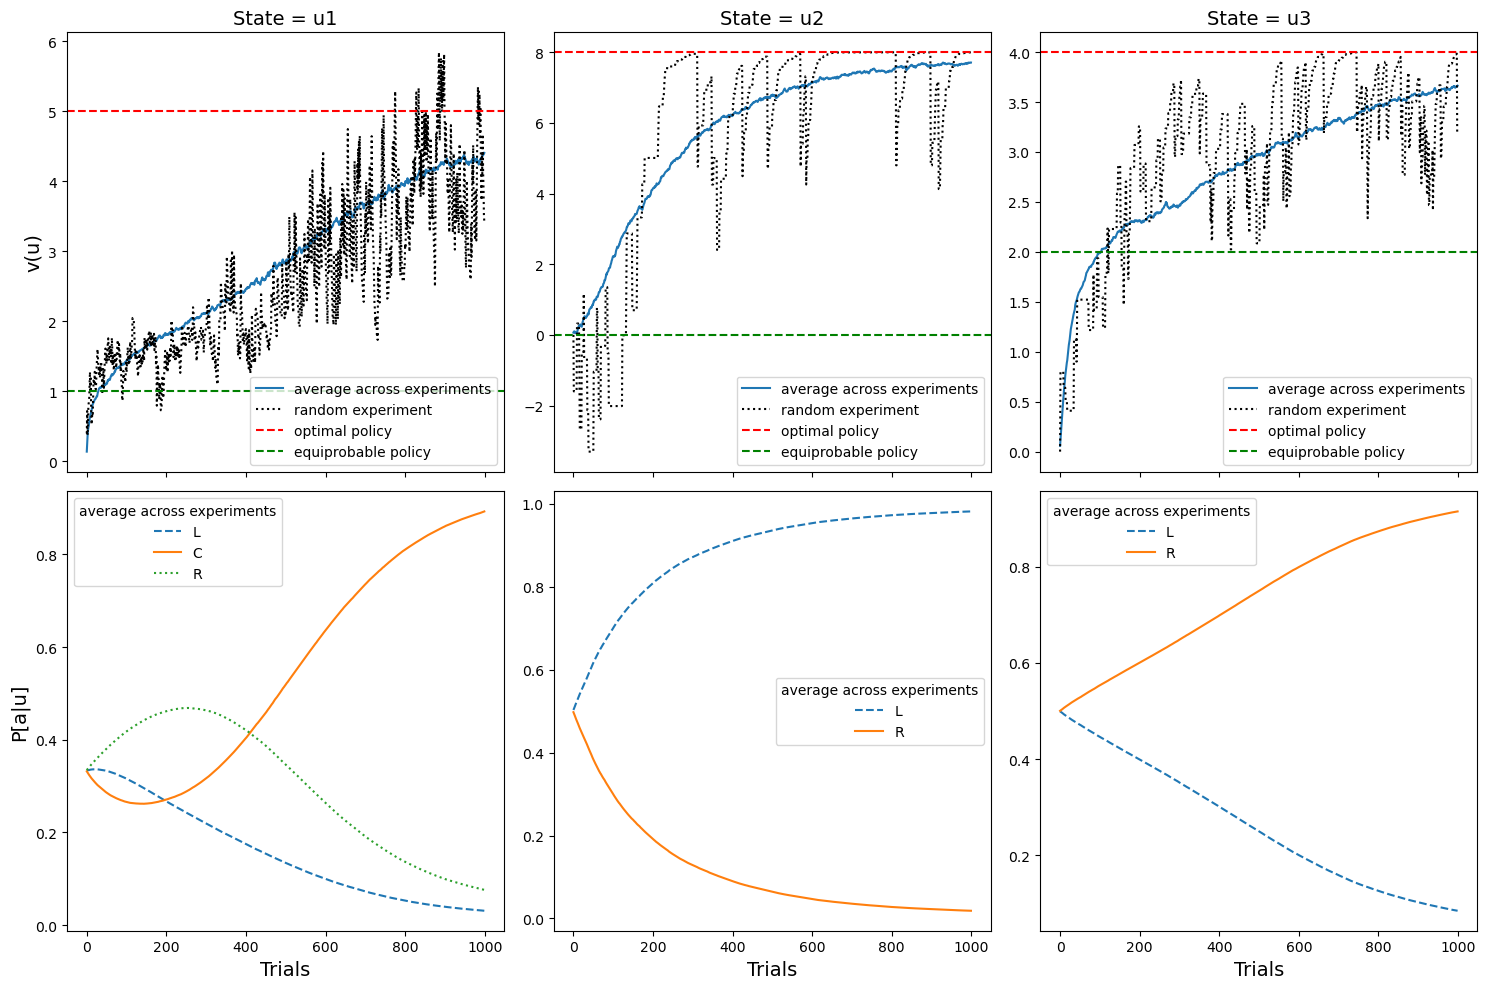

In [21]:
# set parameters
beta = 1
decay_constant = 0
actor_l_r = 0.0075
learning_rate = 0.2
experiments = 500
Trials = 1000
Actor_critic = True
env = Environment()
# run simulation and plot results
plot_results()

Interestingly, the animal learns faster to pick the optimal lever `C` at `u1`, with `C` being the most probable choice at around 450th trial. Prediction values also get closer to optimal. Overal the model seems to be perfrming better. This is due to the fact that lower actor learning rate allows for the model to not get so easily 'seduced' by the immediate reward provided by `R` and thus lever `C` can be tried more frequently in early trials which leads to learning that it is the most optimal choice. Overal, lowering the actor learning rate seemingly facilitates more exploration in the early trials, preventing the model from being biased towards actions with immediate rewards. This exploration is vital for discovering more complex, beneficial strategies.

Generally, increasing the learning rate should just produce the opposite effects, so let's move on to the decay constant. Let's see what happens if the decay constant is not zero this time

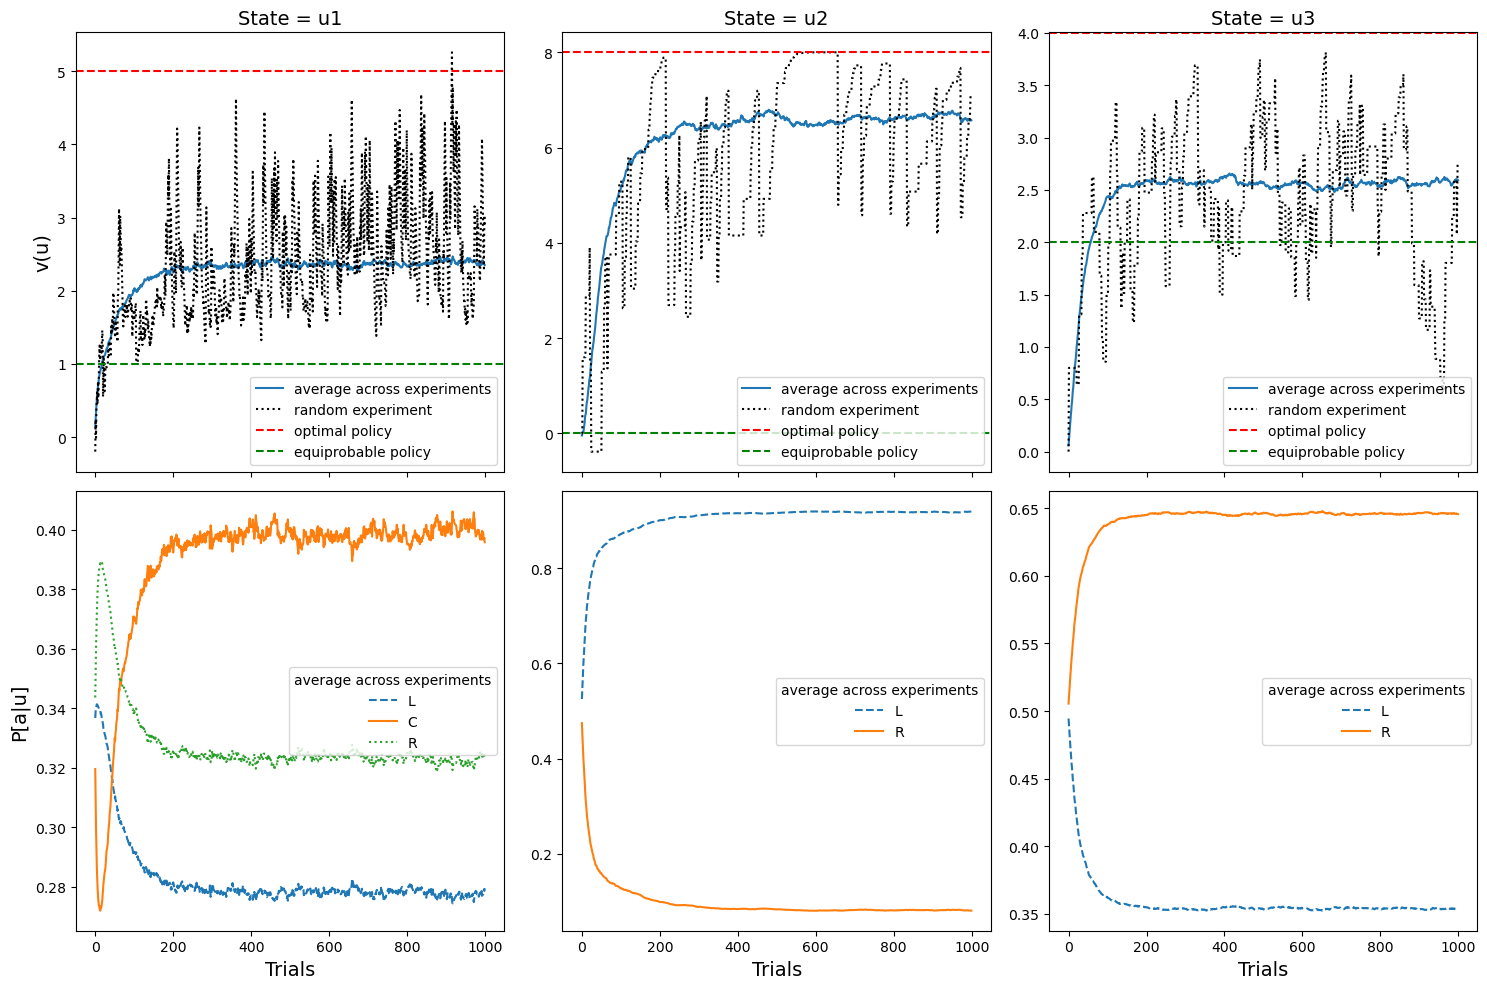

In [15]:
# set parameters
beta = 1
decay_constant = 0.5
actor_l_r = 0.075
learning_rate = 0.2
experiments = 500
Trials = 1000
Actor_critic = True
env = Environment()
# run simulation and plot results
plot_results()

Here we can see that the animal learns pretty fast that choosing lever `C` is the most optimal choice which is reflected by the probability of pressing this lever being the highest after roughly 100th trial. However this choice does not seem to be dominating. After the 200th trial all the probabilities seem to have converged to certain values, namely: 40% for lever `C`, 32% for lever `R` and 28% for lever `L`. So in this scenario we see some variability in animal's actions up to the last trial. The prediction values have respectively converged to some values in between the equiprobabale policy and optimal policy levels. This happens because now the change in action values induced by prediction error delta is compensated by the decay. This way, the decay constant moderates the impact of the prediction error delta on updating the action values, leading to this intermediate convergence. So overall, the animal learns the optimal choice faster, but retains variability in its actions (thus colelcting less reward on average), just as expected.

What if the decay constant is too high? 

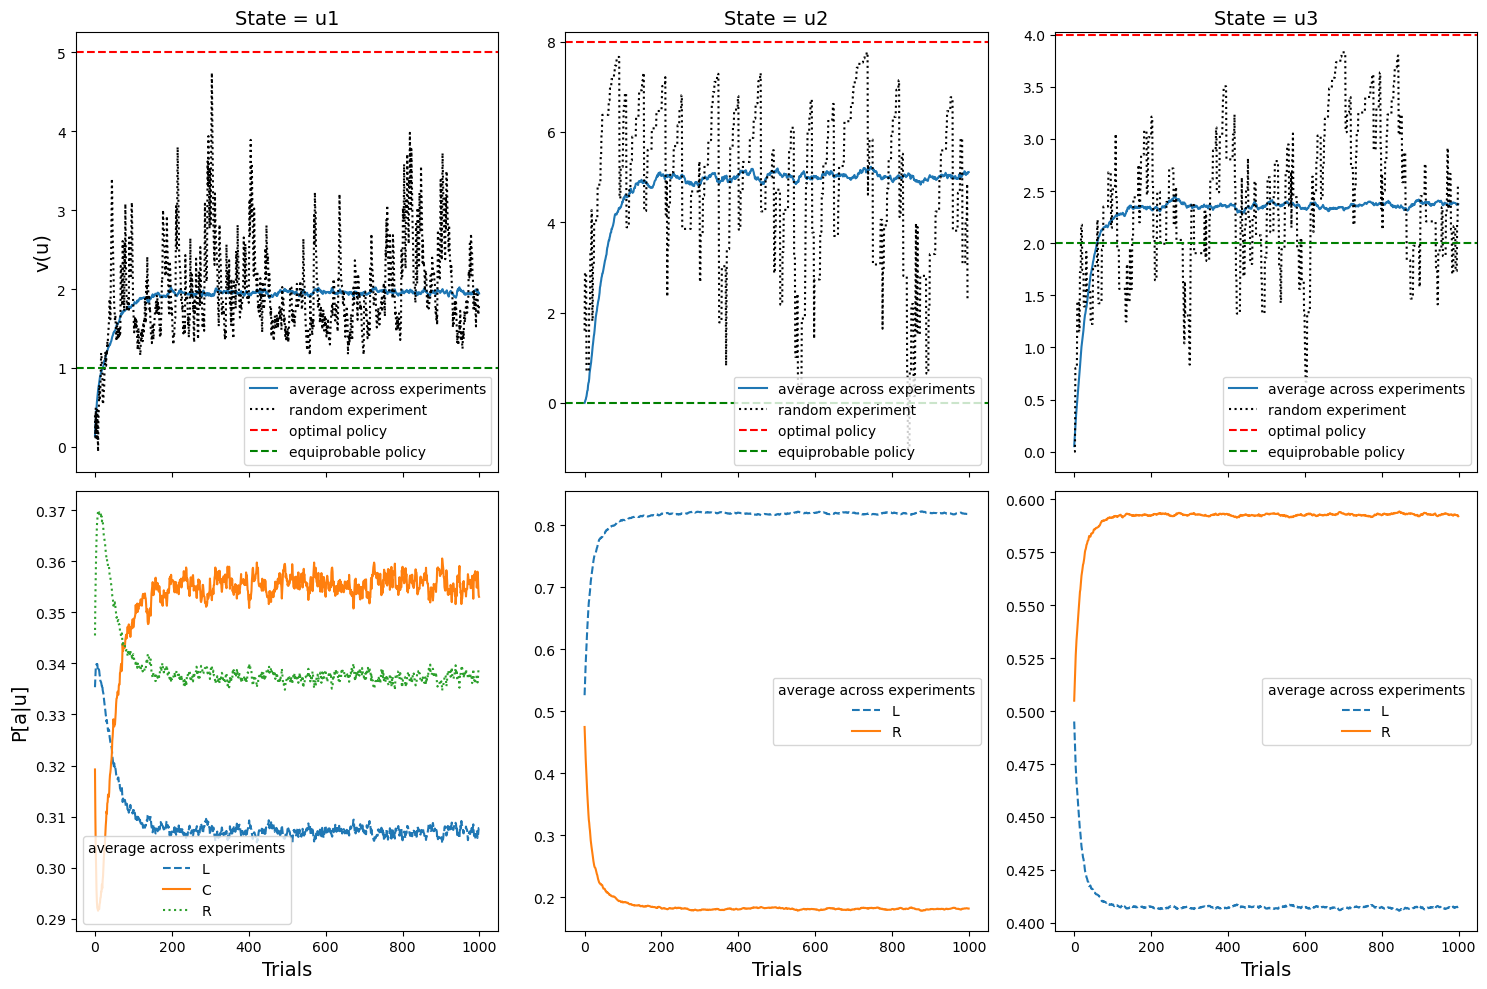

In [22]:
# set parameters
beta = 1
decay_constant = 0.8
actor_l_r = 0.075
learning_rate = 0.2
experiments = 500
Trials = 1000
Actor_critic = True
env = Environment()
# run simulation and plot results
plot_results()

We can see, that choosing the lever `C` is still the most probable outcome at u1, however it is almost as probable as pressing the `R`. Thus overly exploratory behavior, as expected, results in less overal reward collected across the trials. 